In [1]:
!find ../tiles_768 -type f | wc -l

709486


In [1]:
import pandas as pd
import os

def get_image_path(image_id:int):
    return os.path.join('../tiles_768', str(image_id))

I_FOLD = 1
train = pd.read_csv(f"train_fold_{I_FOLD}.csv")
validation = pd.read_csv(f"val_fold_{I_FOLD}.csv")

train['tile_path'] = train['image_id'].apply(lambda x: get_image_path(x))
validation['tile_path'] = validation['image_id'].apply(lambda x: get_image_path(x))
train.head()

,image_id,label,image_width,image_height,is_tma,tile_path
0,8280,HGSC,2964,2964,True,../tiles_768/8280
1,8985,LGSC,65003,31754,False,../tiles_768/8985
2,9183,LGSC,74091,34185,False,../tiles_768/9183
3,9200,MC,3388,3388,True,../tiles_768/9200
4,10252,LGSC,49053,39794,False,../tiles_768/10252


In [5]:
from PIL import Image
import torch
import torch.nn as nn
from transformers import ConvNextV2ForImageClassification
import copy

device = "cuda" if torch.cuda.is_available() else "cpu"
# model_name = "facebook/convnextv2-tiny-22k-384"
# print(f"Using device {device} and model {model_name}")

model = ConvNextV2ForImageClassification.from_pretrained('./convnextv2_config')

model.classifier = nn.Linear(model.classifier.in_features, 5)

state_dict = torch.load('convnextv2_models/fold_0/final.pth', map_location=device)
model.load_state_dict(state_dict, strict=False)
model = model.to(device)

model_vectorizer = copy.deepcopy(model)
model_vectorizer.classifier = nn.Identity()
model_vectorizer = model_vectorizer.to(device)

In [7]:
import torchvision.transforms as transforms

BATCH_SIZE = 8

integer_to_label = {
    0: 'HGSC',
    1: 'CC',
    2: 'EC',
    3: 'LGSC',
    4: 'MC',
}

label_to_integer = {
    'HGSC': 0,
    'CC': 1,
    'EC': 2,
    'LGSC': 3,
    'MC': 4,
}

val_transform = transforms.Compose([
    transforms.Resize(384),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [23]:
import random

model.eval()

preds = []
labels = []
is_tma = []
probabilities = []
vectors = []

with torch.no_grad():
    for _, row in validation.iterrows():
        path = row['tile_path']
        all_files = [f for f in os.listdir(path) if f.lower().endswith('.png')]

        # Prepare a list to hold image tiles
        batch_tiles = []

        sample_size = min(64, len(all_files))
        sampled_files = random.sample(all_files, sample_size)

        for image_name in sampled_files:
            image_path = os.path.join(path, image_name)
            sub_image = Image.open(image_path)

            tile = val_transform(sub_image).unsqueeze(0).to(device)
            batch_tiles.append(tile)
        
        batch_tiles = torch.concat(batch_tiles, axis=0)
        outputs = model(batch_tiles)
        probs = outputs.logits.softmax(dim=1).mean(dim=0)
        batch_vectors = model_vectorizer(batch_tiles)
        batch_vectors = batch_vectors.logits.mean(dim=0).cpu().numpy()

        pred_label = integer_to_label[probs.argmax().detach().cpu().item()]
        label = row['label']

        preds.append(pred_label)
        labels.append(label)
        is_tma.append(row['is_tma'])
        probabilities.append(probs.max().cpu().item())
        vectors.append(batch_vectors)
        
        print(row['image_id'], preds[-1], labels[-1], is_tma[-1], probabilities[-1], vectors[-1].shape)

4 LGSC HGSC False 0.5911375284194946 (768,)
66 HGSC LGSC False 0.4710664451122284 (768,)
91 HGSC HGSC True 0.37388908863067627 (768,)
281 LGSC LGSC False 0.40856367349624634 (768,)
286 EC EC False 0.4296318292617798 (768,)
431 LGSC HGSC False 0.4510672092437744 (768,)
706 HGSC HGSC False 0.3608400821685791 (768,)
970 LGSC HGSC False 0.6682522296905518 (768,)
1020 HGSC HGSC False 0.4113612771034241 (768,)
1080 LGSC HGSC False 0.5559958815574646 (768,)
1101 HGSC HGSC False 0.44324517250061035 (768,)
1252 HGSC HGSC False 0.44288399815559387 (768,)
1289 LGSC HGSC False 0.4300512671470642 (768,)
1295 EC HGSC False 0.4031521677970886 (768,)
1660 CC CC False 0.6518262028694153 (768,)
1666 HGSC HGSC False 0.6945075988769531 (768,)
1774 HGSC HGSC False 0.30878156423568726 (768,)
1925 HGSC HGSC False 0.488925576210022 (768,)
1943 LGSC CC False 0.31885650753974915 (768,)
1952 CC CC False 0.847257137298584 (768,)
2097 LGSC HGSC False 0.44382181763648987 (768,)
2227 MC MC False 0.7102534174919128 (

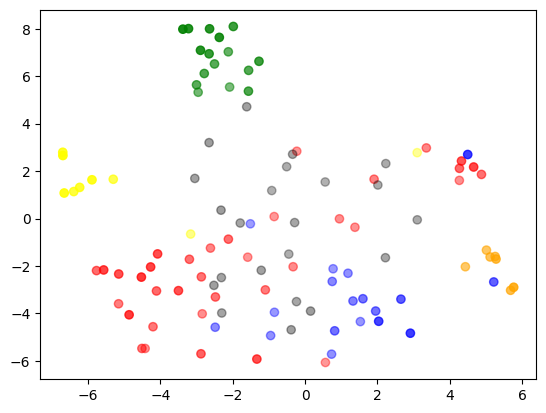

In [110]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

colors = {
    'HGSC': 'red',
    'EC': 'blue',
    'CC': 'green',
    'LGSC': 'yellow',
    'MC': 'orange',
    'Other': 'black',
}

X = np.array(vectors)
X_embedded = TSNE(n_components=2, perplexity=30).fit_transform(X)


plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=[colors[labels[index] if probabilities[index] > np.percentile(probabilities, 20) else 'Other'] for index in range(len(labels))], alpha=[probabilities[index] for index in range(len(probabilities))])
plt.show()